In [1]:
import os
os.chdir("../") # resets notebook directory to repository root folder (DO ONLY ONCE!)
import polars as pl
import pandas as pd
import pyarrow.parquet as pypq
import textwrap
from pathlib import Path
import time

from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
import sys
# Add utils directory in the list of directories to look for packages to import
sys.path.insert(0, os.path.join(os.getcwd(),'utils'))
from read_parquet import *

Using PyArrow strings!


In [3]:
works_by_topic_parquet_folder = "data/works_by_topic_parquet/"
works2topic_by_topic_parquet_folder = "data/works2topic_by_topic_parquet/"
os.makedirs(works2topic_by_topic_parquet_folder, exist_ok=True)

In [4]:
topics = [topic[:-8] for topic in os.listdir(works_by_topic_parquet_folder)]

In [5]:
len(topics)

4516

In [6]:
topic = topics[0]
works_df = read_parquet(works_by_topic_parquet_folder+topic, columns = ["id", "date", "topics"])


Reading 'T14064' from 'data/works_by_topic_parquet/T14064.parquet' using engine='pyarrow'
Read 35,877 rows from 'T14064' in 0.17 sec.
Converting dtypes took 0.00 sec. Size before: 0.00GB, after: 0.00GB


,id,date,topics
0,W7126435799,2026-02-01,T14064_0.3939;T10055_0.0552;T10154_0.0368
1,W7126372280,2026-02-01,T14064_0.2306;T10557_0.0815;T13684_0.0235
2,W7126447841,2026-01-31,T14064_0.1082;T14260_0.0584;T12922_0.049


In [7]:
def flattenList(l):
    return [item for sublist in l for item in sublist]

def get_topic_scores(x):
    ll = flattenList([i.split('_') for i in x.split(';')])
    return ll + [None]*(6-len(ll))

def generate_topic_score_df(parquet_file_path):
    works_df = read_parquet(parquet_file_path, columns = ["id", "date", "topics"], quiet = True)
    works_df['topics'] = works_df['topics'].apply(lambda x: get_topic_scores(x))
    works_df[['t0', 's0', 't1', 's1', 't2', 's2']]=pd.DataFrame(works_df['topics'].tolist(), index=works_df.index)
    del works_df['topics']
    return works_df

def create_topic_score_df(origin_works_parquet_file_path, destination_topic_parquet_file_path, compression='brotli', do_peek = True, do_print = True):
    works_df = generate_topic_score_df(origin_works_parquet_file_path)
    works_df.to_parquet(destination_topic_parquet_file_path, compression=compression)
    if do_print:
        print(f"Successfully generated {destination_topic_parquet_file_path} using {origin_works_parquet_file_path}.")
    if do_peek:
        if do_print:
            print("Here's a peek.")
        peek_parquet(destination_topic_parquet_file_path)

In [8]:
for topic in tqdm(topics):
    origin_works_parquet_file_path = works_by_topic_parquet_folder+topic+".parquet"
    destination_topic_parquet_file_path = works2topic_by_topic_parquet_folder+topic+".parquet"
    create_topic_score_df(origin_works_parquet_file_path, destination_topic_parquet_file_path, do_peek = False, do_print = False)

  0%|          | 0/4516 [00:00<?, ?it/s]

In [9]:
peek_parquet(destination_topic_parquet_file_path)

Name: 'T10091'
Path: 'data/works2topic_by_topic_parquet/T10091.parquet'
Files: 1
Rows: 159,847
Schema:
    id: large_string
    date: large_string
    t0: large_string
    s0: large_string
    t1: large_string
    s1: large_string
    t2: large_string
    s2: large_string
    -- schema metadata --
    pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 1092
5 random rows:


,id,date,t0,s0,t1,s1,t2,s2
0,W7083686573,2030-01-01,T10091,0.8715,T12576,0.0231,T10482,0.02
1,W6963238420,2028-01-01,T10091,0.8168,T14463,0.013,T13434,0.0047
2,W6929729901,2028-01-01,T10091,0.965,T12874,0.0047,T14135,0.0019
3,W6925566458,2028-01-01,T10091,0.8514,T10116,0.0269,T12576,0.0219
4,W7089278898,2026-10-12,T10091,0.9945,T10695,0.0009,T10209,0.0005


In [10]:
destination_topic_parquet_file_path = works2topic_by_topic_parquet_folder+topic+".parquet"
df = read_parquet(destination_topic_parquet_file_path)


Reading 'T10091' from 'data/works2topic_by_topic_parquet/T10091.parquet' using engine='pyarrow'
Read 159,847 rows from 'T10091' in 0.14 sec.
Converting dtypes took 0.00 sec. Size before: 0.02GB, after: 0.02GB


,id,date,t0,s0,t1,s1,t2,s2
0,W7083686573,2030-01-01,T10091,0.8715,T12576,0.0231,T10482,0.02
1,W6963238420,2028-01-01,T10091,0.8168,T14463,0.013,T13434,0.0047
2,W6929729901,2028-01-01,T10091,0.965,T12874,0.0047,T14135,0.0019


<Axes: >

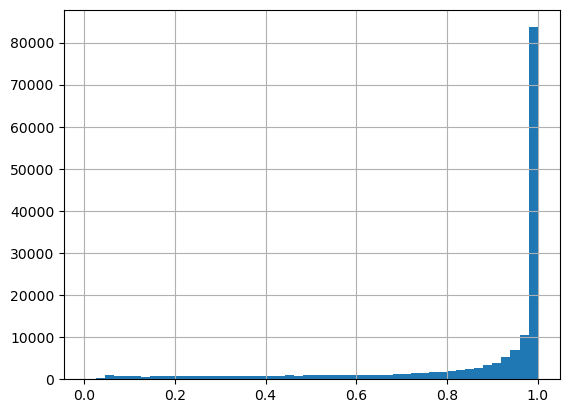

In [11]:
df.s0.astype(float).hist(bins = 50)

<Axes: >

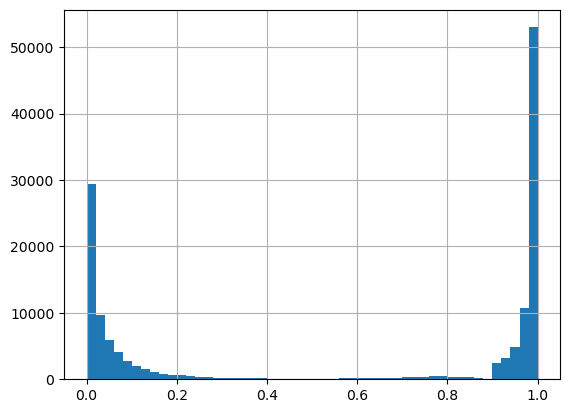

In [12]:
df.s1.astype(float).hist(bins = 50)

<Axes: >

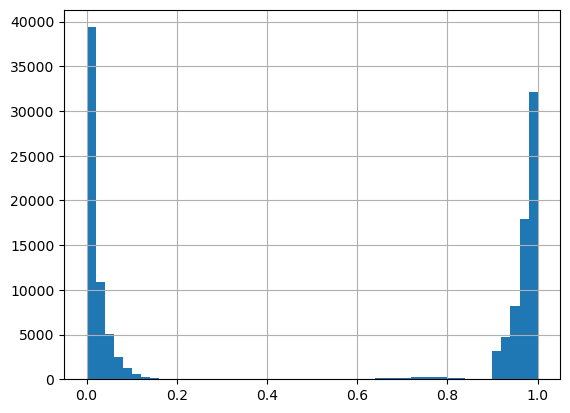

In [13]:
df.s2.astype(float).hist(bins = 50)